In [1]:
import os
import cv2
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose

from glob import glob

In [2]:
inception = 'inceptionv3'
mobilenet = 'mobilenet'
efficientnet = 'efficientnetb0'
paper_model = 'paper_model'

# Matrics Evaluation

In [3]:
def make_df_matrics(backbone):
    history = pickle.load(open('train history/' + backbone + '_trainHistoryDict', "rb"))
    df = pd.DataFrame(history)
    return pd.DataFrame(df.iloc[df.loss.idxmin()]).transpose().rename(index={df.loss.idxmin() : backbone})

In [4]:
pd.concat([make_df_matrics(backbone=inception),
          make_df_matrics(backbone=mobilenet),
          make_df_matrics(backbone=efficientnet),
          make_df_matrics(backbone=paper_model)
           ])

loss  f1-score  iou_score  val_loss  val_f1-score  \
inceptionv3     0.028742  0.971268   0.944338  0.031804      0.968076   
mobilenet       0.029653  0.970371   0.942750  0.031919      0.969069   
efficientnetb0  0.027970  0.972039   0.945792  0.030874      0.969024   
paper_model     0.037411  0.962563   0.928249  0.037140      0.962293   

                val_iou_score  
inceptionv3          0.938229  
mobilenet            0.940148  
efficientnetb0       0.940034  
paper_model          0.927522

In [5]:
def plot_training(backbone, save = False):
    hist = pickle.load(open('train history/'+backbone+'_trainHistoryDict', "rb"))
    fig, axs = plt.subplots(1, 3, figsize = (15, 4))

    training_loss = hist['loss']
    validation_loss = hist['val_loss']

    dice = hist['f1-score']
    dice_validation = hist['val_f1-score']

    jaccard = hist['iou_score']
    jaccard_validation = hist['val_iou_score']

    epoch_count = range(1, len(training_loss) + 1)

    axs[0].plot(epoch_count, training_loss, 'r--')
    axs[0].plot(epoch_count, validation_loss, 'b-')
    axs[0].legend(['Training Loss', 'Validation Loss'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    axs[1].plot(epoch_count, dice, 'r--')
    axs[1].plot(epoch_count, dice_validation, 'b-')
    axs[1].legend(['dice', 'dice_validation'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Dice')

    axs[2].plot(epoch_count, jaccard, 'r--')
    axs[2].plot(epoch_count, jaccard_validation, 'b-')
    axs[2].legend(['jaccard', 'jaccard_validation'])
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Jaccard')

    if save :
        fig.savefig('image result/'+backbone+'_acc_loss_result.svg')

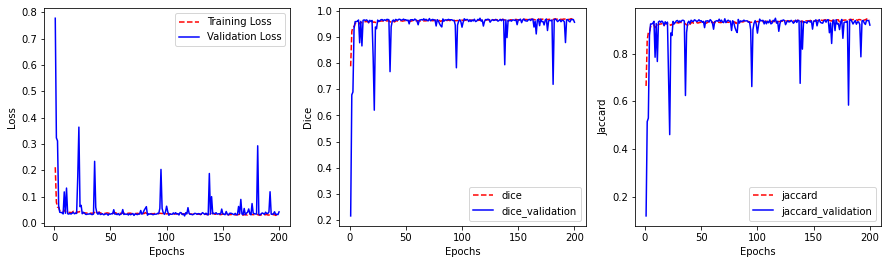

In [6]:
plot_training(inception, save=True)

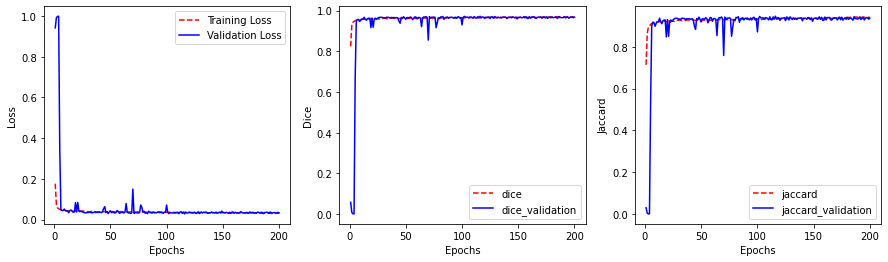

In [7]:
plot_training(mobilenet, save=True)

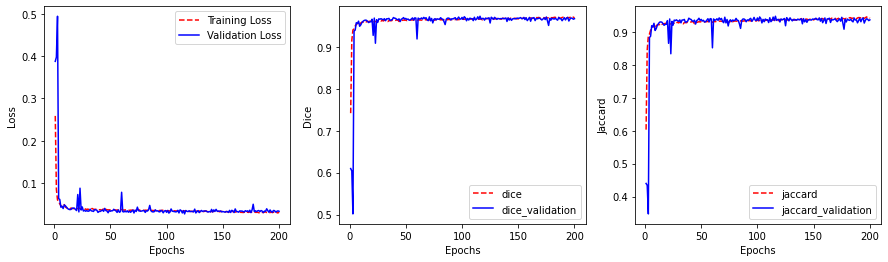

In [8]:
plot_training(efficientnet, save=True)

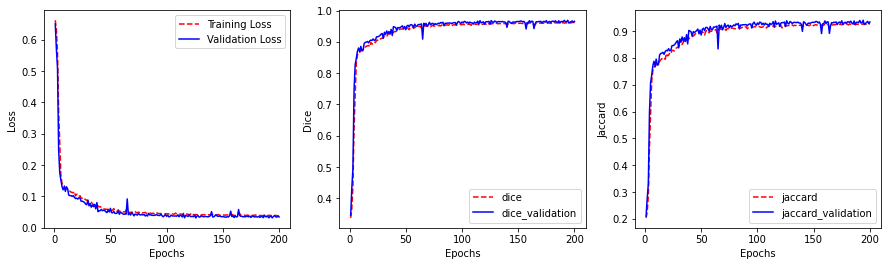

In [9]:
plot_training(paper_model, save=True)

# Training Time

In [10]:
def get_trainingTime(backbone):
    history = pd.read_csv('training time/'+backbone+'_training_time.csv', header=None)
    minute = sum(history[0]/60)
    return round(minute, 2)

In [11]:
pd.DataFrame(data = [get_trainingTime(inception), get_trainingTime(mobilenet),
                     get_trainingTime(efficientnet), get_trainingTime(paper_model)],
             index= [inception, mobilenet, efficientnet, paper_model],
             columns = ['time (in minute)'])

time (in minute)
inceptionv3               250.25
mobilenet                 246.68
efficientnetb0            251.64
paper_model               254.00

# Segmentation Result

In [12]:
def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)

    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)

def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s%s" % (filename, fileext))

        cv2.imwrite(result_file, img)


In [13]:
input_dir = os.path.join('data')
test_dir = os.path.join(input_dir, 'test')
img_test_dir = os.path.join(test_dir, 'CXR_png')
test_img_files = glob(os.path.join(img_test_dir, "*.png"))

In [14]:
import tensorflow as tf

In [15]:
# use local machine
# configuration for my personal gpu to allow memory growth
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [16]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [17]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [18]:
def net(input_size=(512,512,1)):
    inputs = Input(input_size)

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [19]:
def predict_image(backbone):
    if backbone == paper_model:
        model = net(input_size=(512,512,1))
    else:
        model = sm.Unet(backbone,
                        input_shape = (512, 512, 1),
                        activation = 'sigmoid',
                        classes = 1,
                        encoder_weights = None)

    model.load_weights('models/'+backbone+'.hdf5')

    img_test_predict_dir = os.path.join(test_dir, 'predict', backbone)

    test_gen = test_generator(test_img_files, target_size=(512,512))
    results = model.predict_generator(test_gen, len(test_img_files), verbose=1)
    save_result(img_test_predict_dir, results, test_img_files)

In [20]:
predict_image(efficientnet)

d:\sinau\lung segmentation keras\env\lib\site-packages\tensorflow\python\keras\engine\training.py:1939: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


141/141 [==============================] - 19s 108ms/step


In [21]:
predict_image(inception)

d:\sinau\lung segmentation keras\env\lib\site-packages\tensorflow\python\keras\engine\training.py:1939: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


141/141 [==============================] - 17s 105ms/step


In [22]:
predict_image(mobilenet)

141/141 [==============================] - 15s 104ms/step


In [23]:
predict_image(paper_model)

141/141 [==============================] - 16s 104ms/step


In [20]:
images_test = [i for i in os.listdir('data/test/CXR_png') if i.endswith(".png")]

In [21]:
def random_file(number=2):
    list_file=[]
    for i in range(number):
        random_test_img = random.choice(images_test)
        list_file.append(random_test_img)
    return list_file

In [22]:
def show_predict_data(list_file = None,
                      fheight=16,
                      fweight=16,
                      save=False,
                      backbone = None,
                      filename="filename.svg",
                      dir_save='image result/'):

    fig, axs = plt.subplots(len(list_file), 4, figsize=(fheight, fweight))

    for i, file in enumerate(list_file):
        test_img = file

        image = cv2.imread("data/test/CXR_png/" + test_img)
        predict_image = cv2.imread("data/test/predict/"+ backbone +'/'+ test_img)
        mask_image = cv2.imread("data/test/masks/" + test_img)

        image = cv2.resize(image, (512, 512))
        predict_image = cv2.resize(predict_image, (512, 512))
        mask_image = cv2.resize(mask_image, (512, 512))

        axs[i, 0].set_title(test_img)
        axs[i, 0].imshow(image)
        axs[i, 1].set_title("Predicted")
        axs[i, 1].imshow(add_colored_mask(image, predict_image))
        axs[i, 2].set_title("Ground Truth")
        axs[i, 2].imshow(add_colored_mask(image, mask_image))
        axs[i, 3].set_title("Diff.")
        axs[i, 3].imshow(diff_mask(mask_image, predict_image))

        if save:
            fig.savefig(fname=dir_save+filename)

In [23]:
list_filePredict=random_file(2)

In [24]:
# list_filePredict = ['CHNCXR_0603_1.png', 'MCUCXR_0251_1.png']

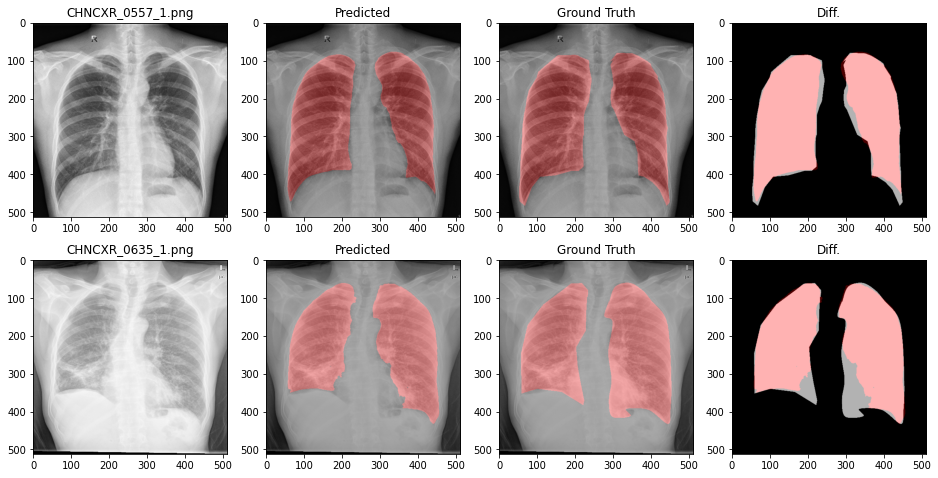

In [25]:
show_predict_data(list_file = list_filePredict, backbone = inception, fweight=8, save=True, filename=inception+'_result.svg')

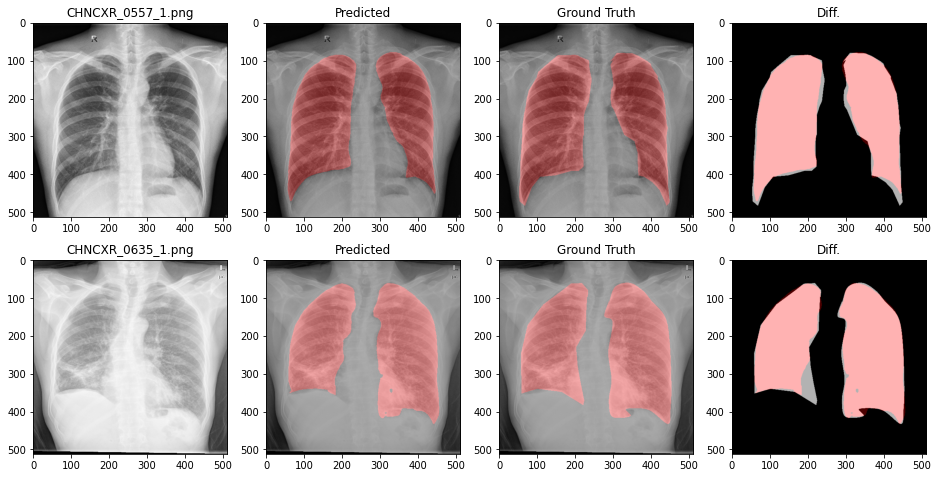

In [26]:
show_predict_data(list_file = list_filePredict, backbone = mobilenet, fweight=8, save=True, filename=mobilenet+'_result.svg')

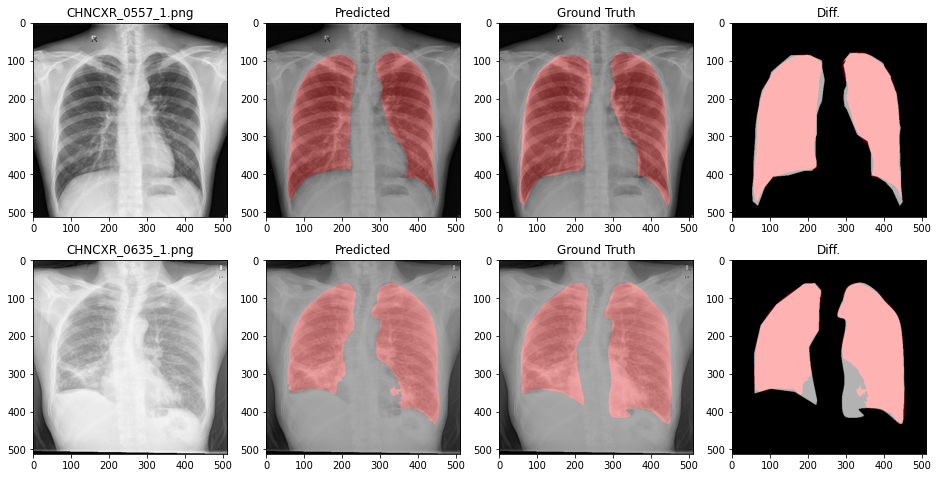

In [27]:
show_predict_data(list_file = list_filePredict, backbone = efficientnet, fweight=8, save=True, filename=efficientnet+'_result.svg')

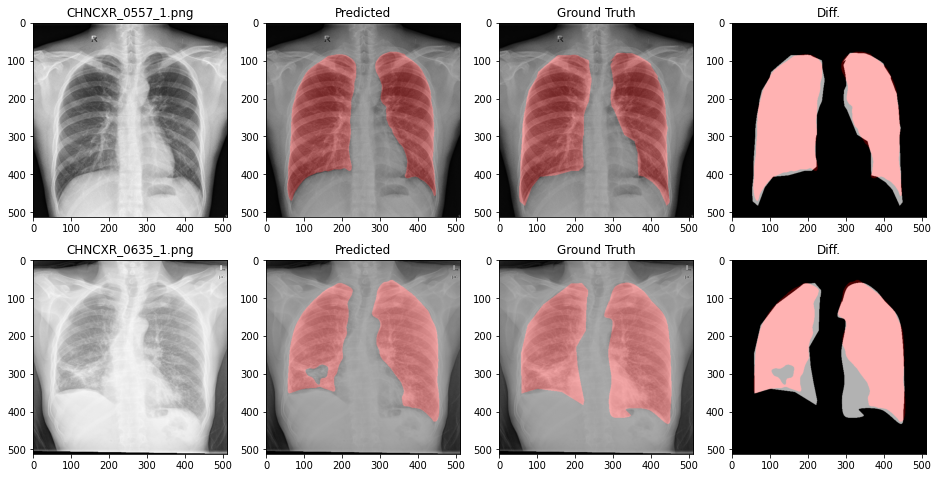

In [28]:
show_predict_data(list_file = list_filePredict, backbone = paper_model, fweight=8, save=True, filename = paper_model+'_result.svg')

In [29]:
from sklearn.metrics import jaccard_score, f1_score

In [30]:
def get_dice(dir_true, dir_pred):
    y_true = [i for i in os.listdir(dir_true) if i.endswith(".png")]

    def adjust_mask(mask):
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0

        return mask

    list_dice = []
    list_jaccard = []

    for i in y_true:
        # print(i)
        # print(k)

        test_img = i

        y_true = cv2.imread(dir_true + test_img)
        y_pred = cv2.imread(dir_pred + test_img)

        y_true = cv2.resize(y_true, (512, 512))
        y_pred = cv2.resize(y_pred, (512, 512))

        y_true = adjust_mask(y_true)
        y_pred = adjust_mask(y_pred)

        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()

        jjaccard = jaccard_score(y_true_f, y_pred_f)
        ddice = f1_score(y_true_f, y_pred_f)

        list_dice.append(ddice)
        list_jaccard.append(jjaccard)

    return np.mean(list_dice), np.mean(list_jaccard)

In [31]:
pd.DataFrame(data = [get_dice('data/test/masks/', 'data/test/predict/inceptionv3/'),
                     get_dice('data/test/masks/', 'data/test/predict/mobilenet/'),
                     get_dice('data/test/masks/', 'data/test/predict/efficientnetb0/'),
                     get_dice('data/test/masks/', 'data/test/predict/paper_model/')],
             index= [inception, mobilenet, efficientnet, paper_model],
             columns = ['dice', 'jaccard_score'])

dice  jaccard_score
inceptionv3     0.963558       0.931206
mobilenet       0.964456       0.932490
efficientnetb0  0.966852       0.936744
paper_model     0.962623       0.929022